# 2 Dimensional Scans
Outputting the graphs of the data collected by running the robot :) This data is just for viewing purposes, there is a separate notebook for testing the pathfinder modules.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

from mpl_toolkits import mplot3d
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
path = os.path.abspath('..\\')
print("Available test files:")
file_itr = 0
while os.path.exists(path + "\\Scans\\test_%s.json" % file_itr):
    print("\t\\Scans\\test_%s.json" % file_itr)
    file_itr +=1
file_itr = 0
while os.path.exists(path + "\\Debugging Scripts\\test_%s.json" % file_itr):
    print("\t\\Debugging Scripts\\test_%s.json" % file_itr)
    file_itr +=1


Available test files:
	\Scans\test_0.json
	\Scans\test_1.json
	\Scans\test_2.json
	\Scans\test_3.json
	\Scans\test_4.json
	\Scans\test_5.json
	\Scans\test_6.json
	\Scans\test_7.json
	\Scans\test_8.json
	\Scans\test_9.json
	\Scans\test_10.json
	\Scans\test_11.json


In [76]:
debug_mode = True
save_figs = True
file_no = 10

if save_figs:
    plt.rcParams['figure.dpi'] = 500
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    })
else:
    plt.rcParams['figure.dpi'] = 200

In [77]:
# current_file = r"\Debugging Scripts\test_%s.json" % file_no
current_file = r"\Scans\test_%s.json" % file_no
path = os.path.abspath('..\\') + current_file

if debug_mode:
    print(path)

with open(path, 'r') as infile:
    json_data = json.load(infile)

# print(json_data)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
max_point = json_data["max_point"]

if debug_mode:
    for i in json_data.keys():
        if i != "points":
            print(f"{i}: {json_data[i]}")
    # print(point_mags[0])
    # print(max_point)
    # print(resolution)
    # print(r_o_m)

c:\Users\ander\Documents\COBOT-Transducer-Control-Code\Scans\test_10.json
range of motion: {'X': [0, 0], 'Y': [0, 0], 'Z': [-14, 14], 'Rx': [0, 0], 'Ry': [-20, 20], 'Rz': [0, 0]}
resolution: [0.5, 0.5]
max_point: [[[0.0, 0.0, 4.0], [0.0, -0.5, 0.0]], 668.508]


In [78]:
# Zs = []
# Rxs = []
# Rys = []
# mags = []

# for p in point_mags:
#     Zs.append(p[0][0][2])
#     Rxs.append(p[0][1][0])
#     Rys.append(p[0][1][1])
#     mags.append(p[1])

# Gonna find the set of Rxs and Rys corresponding only to the Z value found at the max point
# Then do the same for the other guys
r = dict()
active_rom = []
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2
    if r[DoF] != 0.0:
        active_rom.append(DoF)

indeces = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
points = np.array([[p[0][indeces[a][0]][indeces[a][1]] for a in active_rom] for p in point_mags])
magss = np.array([[p[1] for p in point_mags]])
magss = magss.T

np_all = np.hstack((points,magss))

dat = pd.DataFrame(data = np_all, columns=["Z","R","mag"])
print(dat.head())
mp = dat.loc[dat['mag'].idxmax()]
print(mp)

      Z     R      mag
0 -14.0 -19.5  151.524
1 -14.0 -19.0   59.511
2 -14.0 -18.5   62.105
3 -14.0 -18.0   66.988
4 -14.0 -17.5   62.105
Z        4.000
R       -0.500
mag    668.508
Name: 2953, dtype: float64


Maximum magnitude:  668.508
Minimum magnitude: 57.07
Median magnitude: 66.988


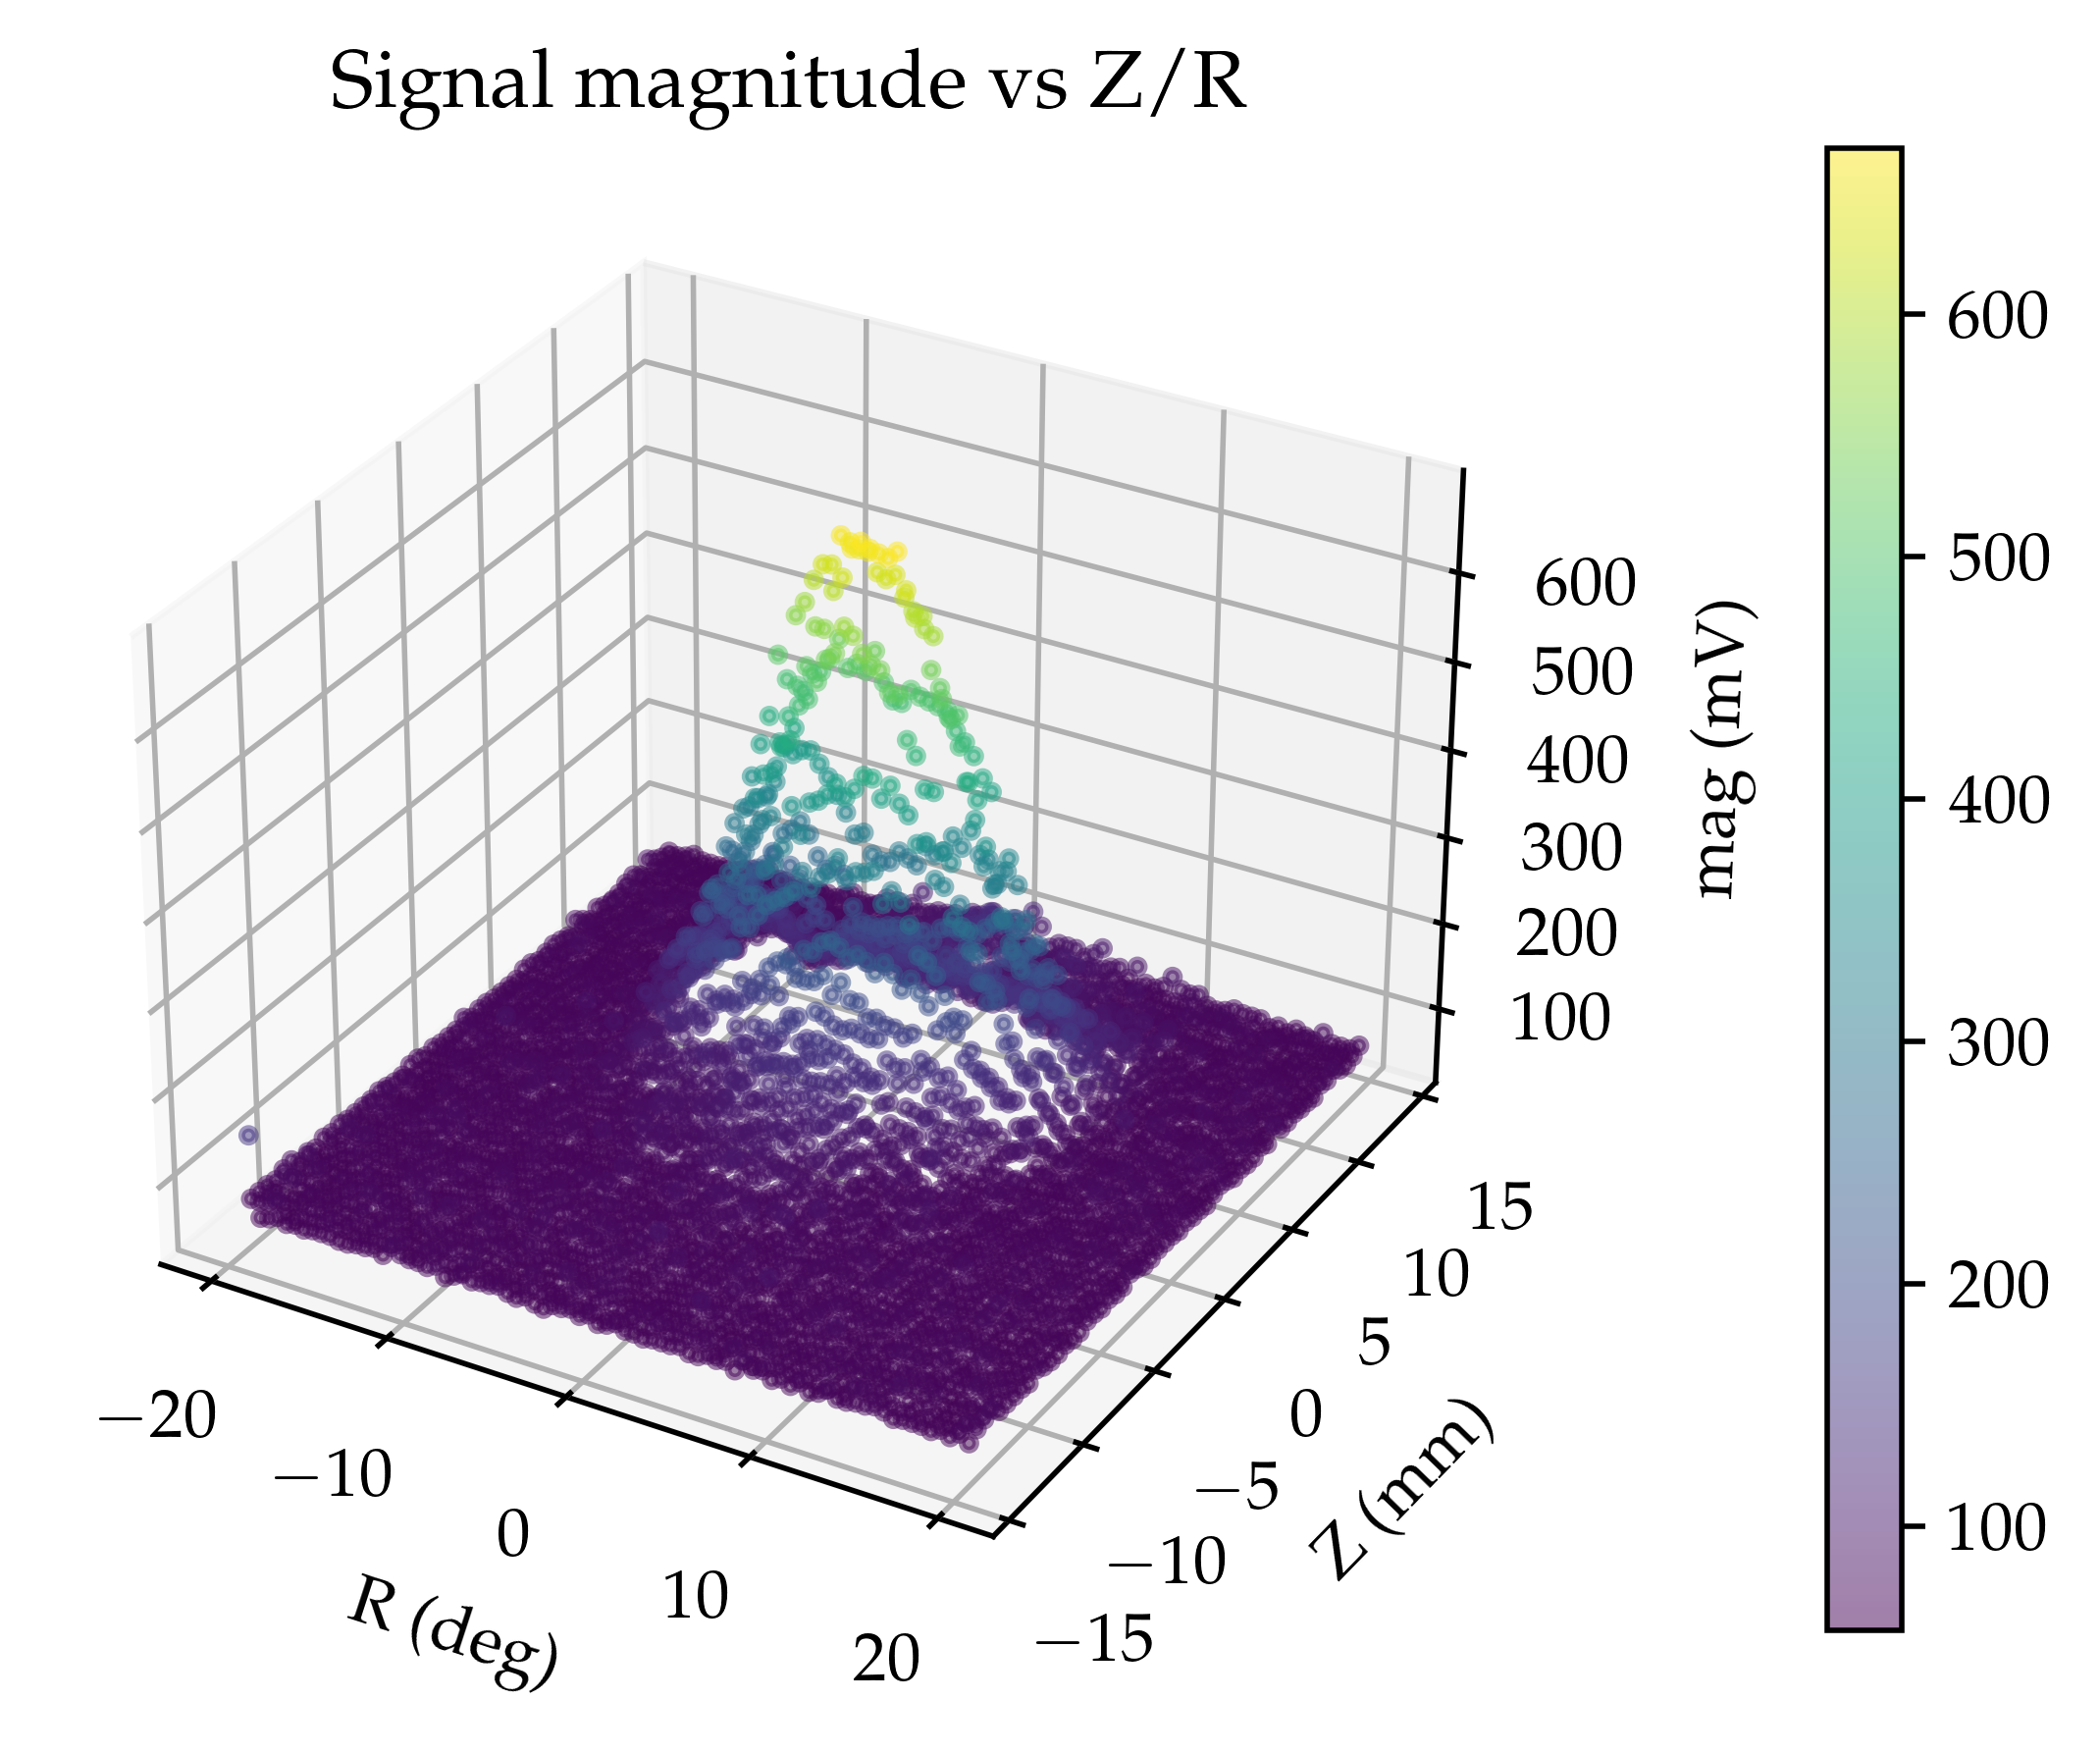

668.508


In [79]:
ax = plt.axes(projection='3d')

if debug_mode:
    print(f"Maximum magnitude:  {max(dat['mag'])}")
    print(f"Minimum magnitude: {min(dat['mag'])}")
    print(f"Median magnitude: {np.median(dat['mag'])}")

med = np.median(dat['mag'])
# dat2 = dat[np.all([dat['mag'] > med*1.3, dat['Ry'] > 5],axis=0)]
dat2 = dat[dat['mag'] > med*1.3]

# fig = ax.scatter(dat2['Rx'], dat2['Ry'], dat2['Z'], c=dat2['mag'], cmap='viridis', alpha=0.1,s=4)
fig = ax.scatter(dat['R'], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.5,s=4)

ax.set_xlabel("R (deg)")
ax.set_ylabel("Z (mm)")
ax.set_zlabel("mag (mV)")
ax.set_title("Signal magnitude vs Z/R")

plt.colorbar(fig, pad=0.13)
if save_figs:
    plt.savefig("figures\\2D_fullscan_render_test_%s.jpg" % file_no, dpi=400)
plt.show()

print(max(dat['mag']))


In [80]:
# "mps" stands for "max points," or all the points in Rx/Ry space that occur at the max
# value of Z, rotated for each of the other dimensions
# mp = max_point[0]

zmps = dat[dat['Z'] == mp['Z']].reset_index(drop=True)
Rmps = dat[dat['R'] == mp['R']].reset_index(drop=True)

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(f"Shape of points array: {points.shape}")
    print(f"Shape of magnitudes array: {magss.shape} \n(Should be 1-D, same length as points array)")
    print(f"Tenth point_mag item (representative): {np_all[10]}")
    print(f"Testing the Z-max-points array:\n{zmps.head(4)}\n(Should be all the same as in the maxpoint)")
    print(f"Maximum point: {mp}")

Active range of motion: ['Z', 'Ry']
Shape of points array: (4614, 2)
Shape of magnitudes array: (4614, 1) 
(Should be 1-D, same length as points array)
Tenth point_mag item (representative): [-14.    -14.5    62.105]
Testing the Z-max-points array:
     Z     R     mag
0  4.0 -20.0  66.988
1  4.0 -19.5  62.105
2  4.0 -19.0  62.105
3  4.0 -18.5  62.105
(Should be all the same as in the maxpoint)
Maximum point: Z        4.000
R       -0.500
mag    668.508
Name: 2953, dtype: float64


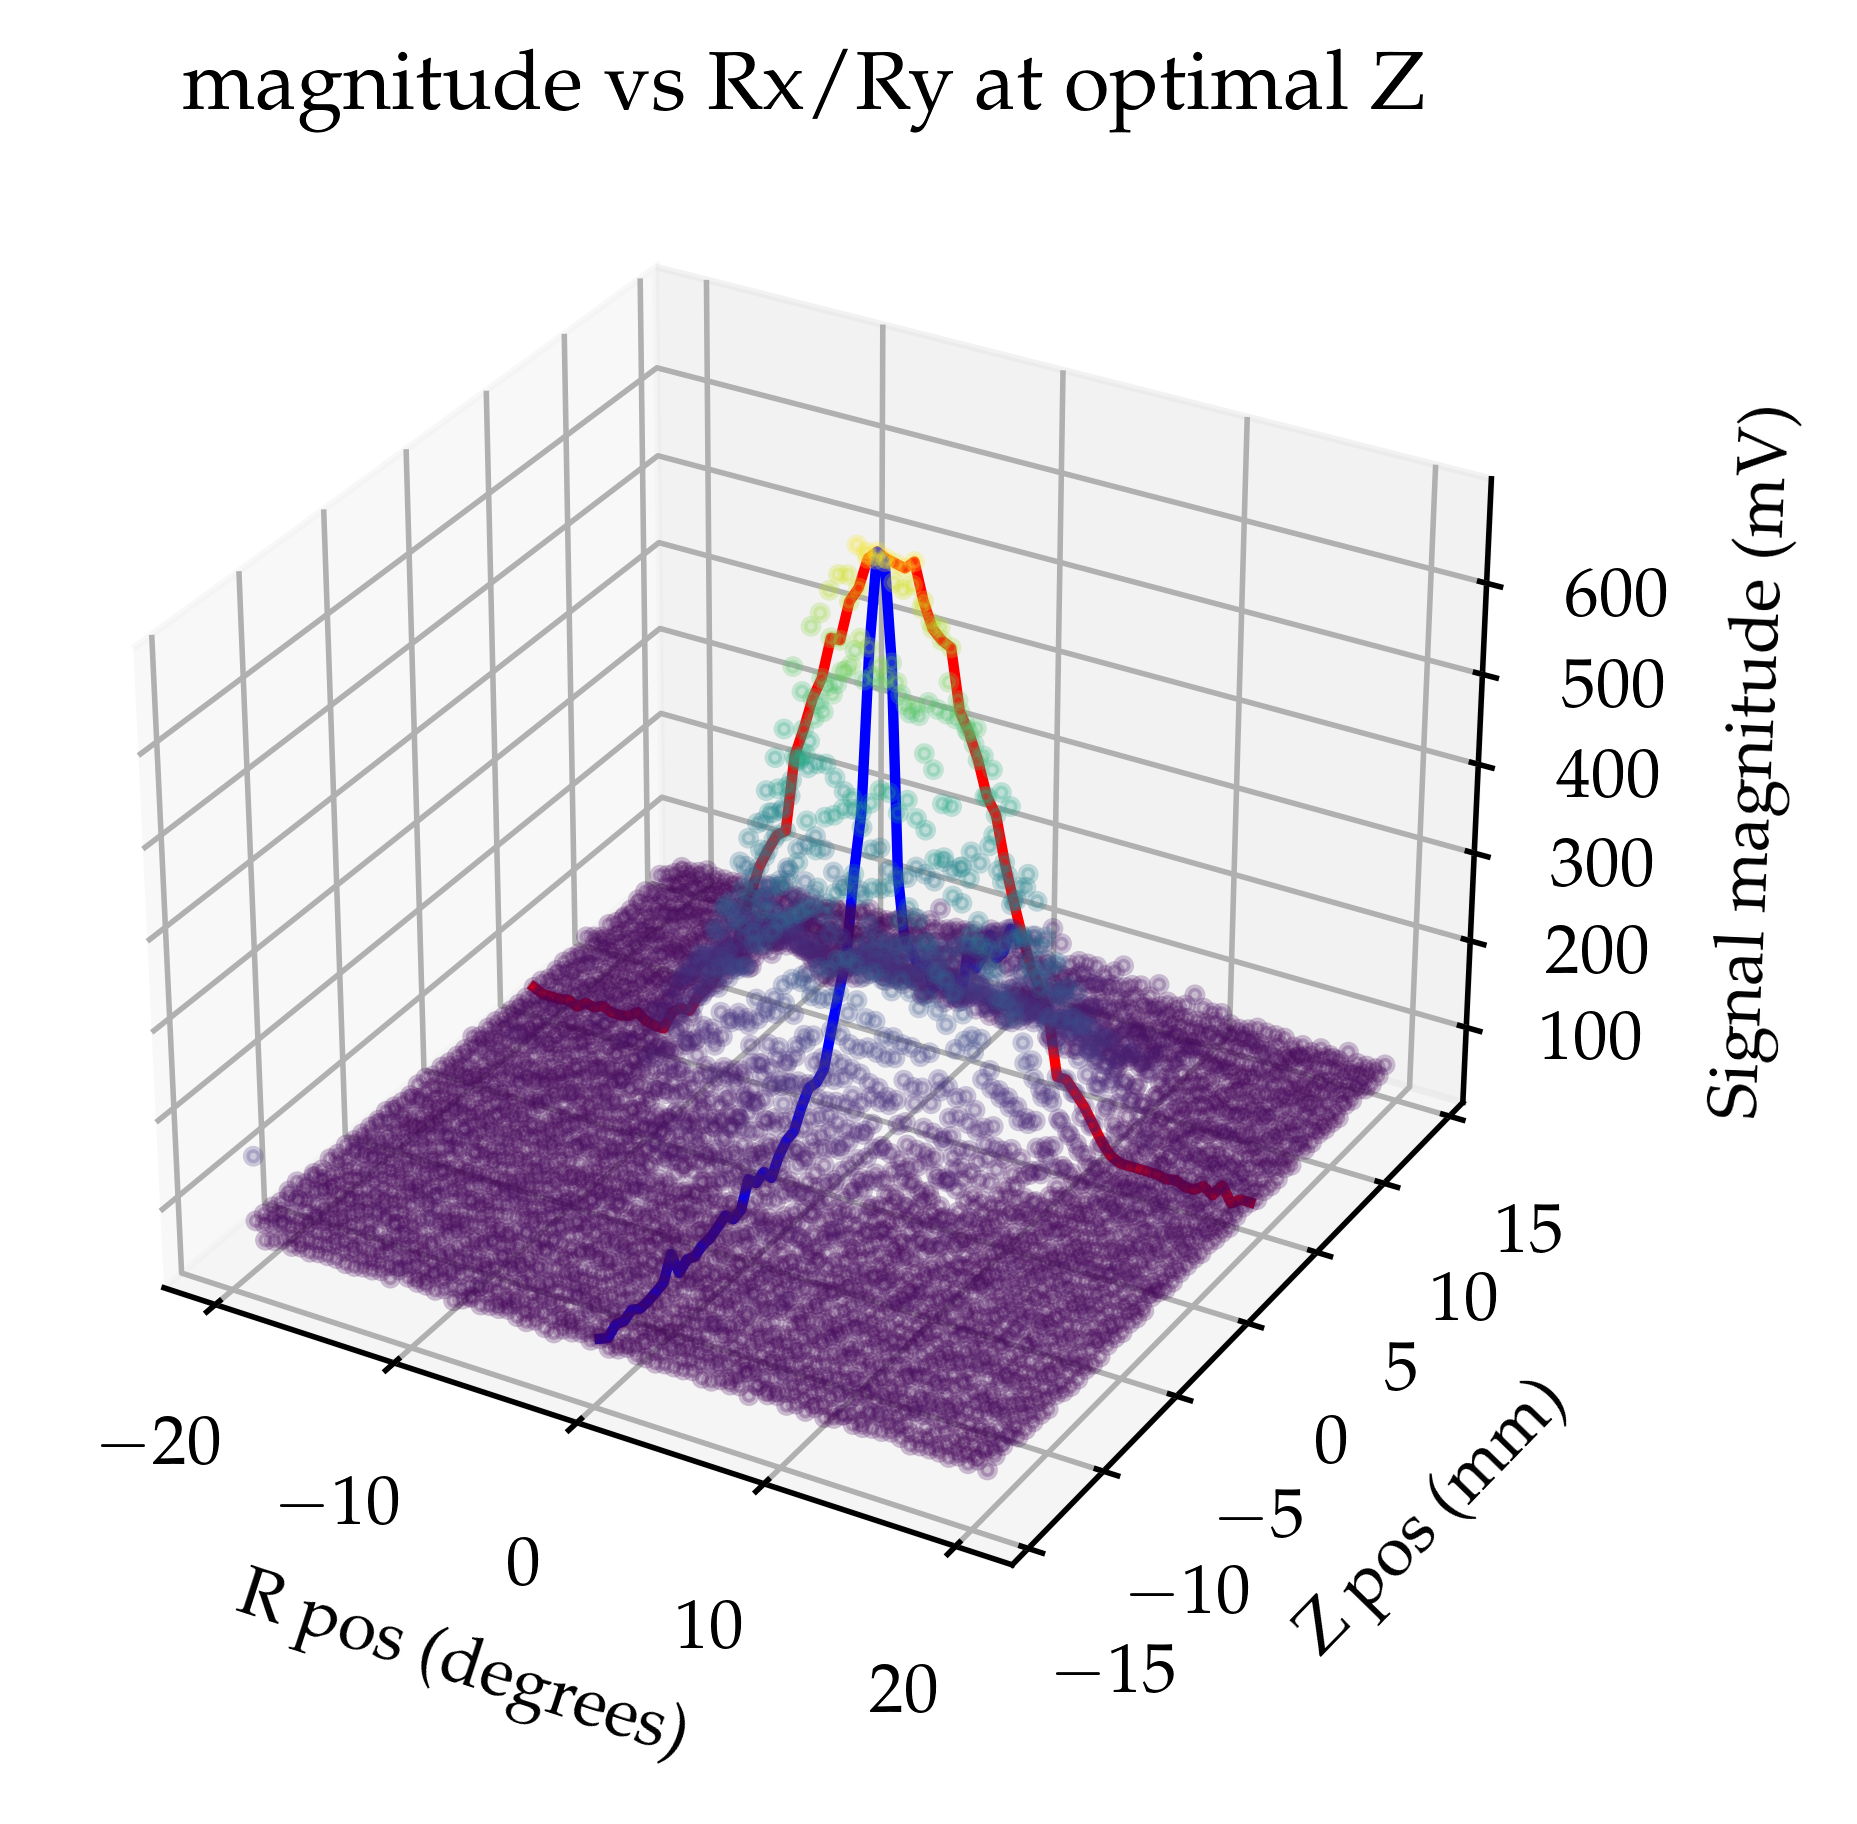

<Figure size 3000x2000 with 0 Axes>

In [81]:
# fig2 = plt.figure(figsize=(14,4), constrained_layout=True)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

# tax = fig2.add_subplot(1,3,1, projection='3d')
tax = plt.axes(projection='3d')
tax.scatter3D(dat['R'], dat['Z'], dat['mag'], c=dat['mag'], cmap='viridis', alpha=0.25,s=4)
tax.plot3D(zmps['R'], zmps['Z'], zmps['mag'],c='r')
tax.plot3D(Rmps['R'], Rmps['Z'], Rmps['mag'],c='b')
tax.set_title("magnitude vs Rx/Ry at optimal Z")
tax.set_xlabel("R pos (degrees)")
tax.set_ylabel("Z pos (mm)")
tax.set_zlabel("Signal magnitude (mV)")

plt.show()


if save_figs:
    plt.savefig("figures\\2D_fullscan_trace_%s.jpg" % file_no, dpi=400)
plt.show()

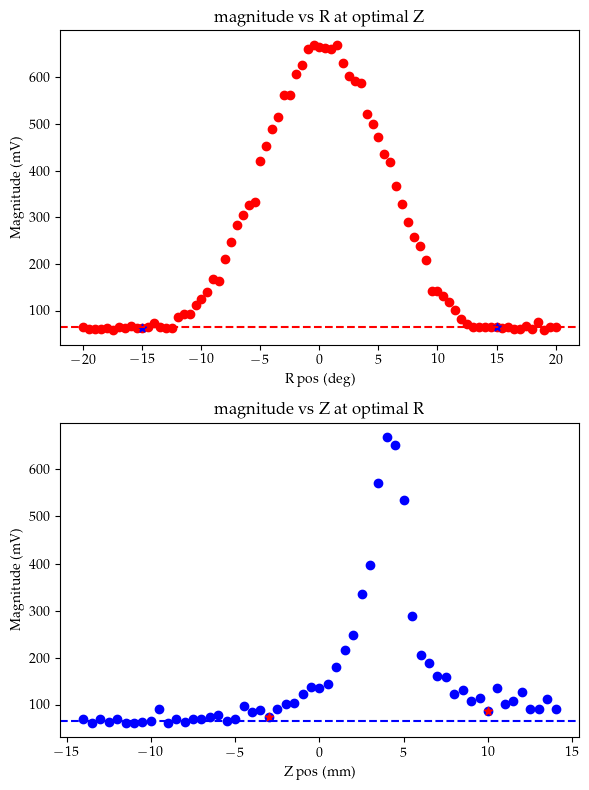

In [82]:
fig3 = plt.figure(figsize=(6,8), dpi=100)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.8, 
#                     hspace=0.4)

# interpolation_windows = {'R': [27,77], 'Z': [11,20]} # Best for scan_11.json
interpolation_windows = {'R': [10,70], 'Z': [22,48]}

tax = fig3.add_subplot(211)
tax.scatter(zmps['R'],zmps['mag'], c='r')

tax.axhline(np.median(dat['mag']), c='r',ls='--')
# tax.axhline(np.median(dat['mag']), c='r',ls='--')
# a = [16,64]
a = interpolation_windows['R']
tax.scatter(zmps['R'][a],zmps['mag'][a], c='b', marker='*')
tax.set_title("magnitude vs R at optimal Z")
tax.set_xlabel("R pos (deg)")
tax.set_ylabel("Magnitude (mV)")

tax = fig3.add_subplot(212)
tax.scatter(Rmps['Z'],Rmps['mag'], c='b')
tax.axhline(np.median(dat['mag']), c='b',ls='--')
# a = [25,45]
a=interpolation_windows['Z']
tax.scatter(Rmps['Z'][a],Rmps['mag'][a], c='r', marker='*')

tax.set_title("magnitude vs Z at optimal R")
tax.set_xlabel("Z pos (mm)")
tax.set_ylabel("Magnitude (mV)")

fig3.tight_layout()

if save_figs:
    fig3.savefig("figures\\2D_degree_isolation_%s.jpg" % file_no, dpi=400)
plt.show()

In [91]:
from fit_funcs import *

funcs = [gauss,rational_2,polynomial_2,inv_absolute,inv_abs_poly_4]
# funcs = [gauss,gauss_plus,rational_2,polynomial_2]

Gaussian
[5.43563823e+02 1.24401296e-01 3.99629799e+00]
2nd Order rational function
[  523.54833911 -2967.14064536  2750.28135047   222.0892393 ]
2nd order polynomial (is terrible)
[ -9.64396496  70.25487718 247.74444009]
Rational absolute value function
[718.37853582   4.19385857   0.79668347]


c:\Users\ander\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Rational absolute value 4th degree polynomial
[-2.09099377e+03  1.00000000e+00  1.66529186e+00  2.17922439e+00
 -4.44303415e-01 -3.83141216e-01  1.13024414e+01  2.99418395e+02]


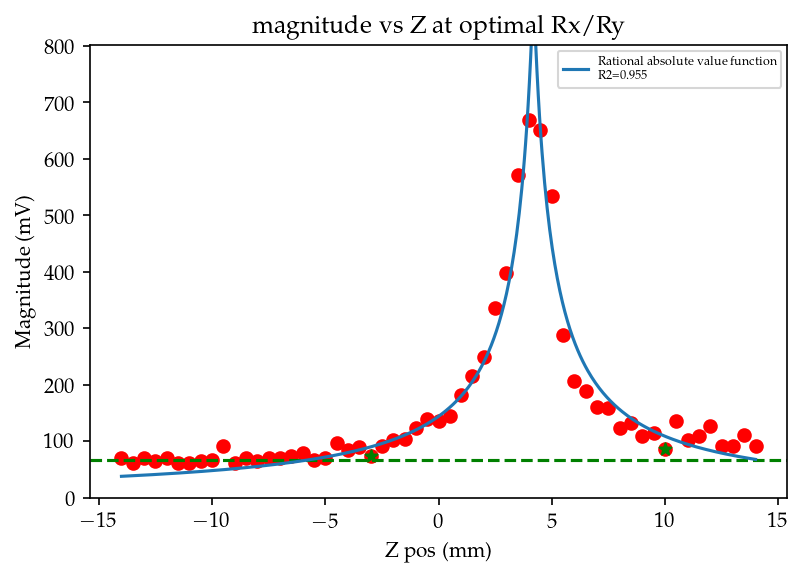

In [92]:
fig4 = plt.axes()
fig4.get_figure().dpi=150

t = {'Z': {'data': Rmps, 'color1': 'r', 'noise': np.median(dat['mag']), 'color2':'g', \
    'header':'magnitude vs Z at optimal Rx/Ry', 'x-axis': "Z pos (mm)"}, \
    'R': {'data': zmps, 'color1':'b', 'noise': np.median(dat['mag']), 'color2':'r', \
    'header':'magnitude vs R at optimal Z', 'x-axis':"Ry ang (deg)"}}

b = "Z"
a = interpolation_windows[b]

fig4.scatter(t[b]['data'][b],t[b]['data']['mag'], c=t[b]['color1'])

fig4.scatter(t[b]['data'][b][a],t[b]['data']['mag'][a], c=t[b]['color2'], marker='*')
fig4.axhline(t[b]['noise'], c='g',ls='--')

# x = np.linspace(t[b][0].reset_index()[b][a[0]],t[b][0].reset_index()[b][a[1]])
x = np.linspace(min(t[b]['data'][b]),max(t[b]['data'][b]),500)

x_data = t[b]['data'][b][a[0]:a[1]]
y_data = t[b]['data']['mag'][a[0]:a[1]]

for fun in funcs:
    popt, pcov = curve_fit(fun, x_data, y_data,maxfev = 5000)
    if debug_mode:
        print(fun.__doc__)
        print(popt)
    r2 = r_squared(fun, popt, x_data, y_data)
    if r2 > 0.6:
        fig4.plot(x, fun(x, *popt), label=fun.__doc__ + f"\n R2={r2:0.3f}")


x_data = t[b]['data'][b]
y_data = t[b]['data']['mag']

fig4.set_title(t[b]['header'])
fig4.set_xlabel(t[b]['x-axis'])
fig4.set_ylabel("Magnitude (mV)")
fig4.legend(prop={'size':6})
fig4.set_ybound([0, t[b]['data']['mag'].max() * 1.2])

if save_figs:
    fig4.get_figure().savefig(f"figures\\2D_{b}_axis_funcs_{file_no}.jpg", dpi=400)